<a href="https://colab.research.google.com/github/tranmanhcuong253/Hierarchical-Attention-Network/blob/main/Hierarchial_Attention_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare Data

**Getting GloVe for word embedding**

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-04-14 11:26:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-14 11:26:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-14 11:26:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data
/content


In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import os
import csv
import pandas as pd
import torch
from torch.utils.data import Dataset
from nltk.tokenize import sent_tokenize,word_tokenize
from sklearn.datasets  import fetch_20newsgroups

**Create dataset from sklearn.fetch_20newsgroups dataset**

Get the vocabulary set from the whole data. Using `transform()` method to encode each word to their relate index in GloVe list as numerical form

In [38]:
class News20Dataset(Dataset):
  '''
  A dataset class to be used in torch Dataloader to create batches
  '''
  def __init__(self,word_map_path,max_sent_length=150,max_doc_length=40,is_train=True):
    """
    :param cache_data_path: folder where data files are stored
    :param word_map_path: path for vocab dict, used for embedding
    :param max_sent_length: maximum number of words in a sentence
    :param max_doc_length: maximum number of sentences in a document
    :param is_train: true if TRAIN mode, false if TEST mode
    """
    self.max_sent_length = max_sent_length
    self.max_doc_length = max_doc_length
    self.split = 'train' if is_train else 'test'
    #Get Dataset
    self.data = fetch_20newsgroups(
        subset=self.split,
        categories=['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'],
        shuffle=False,
        remove=('headers','footers','quotes')
    )
    #Get Vocabulary set
    self.vocab = pd.read_csv(
        filepath_or_buffer = word_map_path,
        header=None,
        sep=' ',
        quoting=csv.QUOTE_NONE,
        usecols=[0]).values[:50000]
    self.vocab=['<pad>','<unk>'] + [word[0] for word in self.vocab]

    #REFACTOR
  def transform(self,text):
    # encode document
    doc = [
        [self.vocab.index(word) if word in self.vocab else 1 for word in word_tokenize(text=sent)]
        for sent in sent_tokenize(text=text)]  # if len(sent) > 0
    doc = [sent[:self.max_sent_length] for sent in doc][:self.max_doc_length]
    num_sents = min(len(doc), self.max_doc_length)

    # skip erroneous ones
    if num_sents == 0:
        return None, -1, None

    num_words = [min(len(sent), self.max_sent_length) for sent in doc][:self.max_doc_length]

    return doc, num_sents, num_words

  def __getitem__(self,i):
    label = self.data['target'][i]
    text = self.data['data'][i]

    doc,num_sents,num_words=self.transform(text)

    if num_sents==-1:
      return None

    return doc,label,num_sents,num_words

  def __len__(self):
        return len(self.data['data'])

  @property
  def vocab_size(self):
      return len(self.vocab)

  @property
  def num_classes(self):
      return 4
      # return len(list(self.data.target_names))




Prepares the batched data for input to a neural network model, ensuring that documents and sentences are properly represented as tensors and have the same size and shapes

Create this function to use in `collate_fn` in DataLoader: a function that specifies how individual data samples should be batched together. When you have a dataset where each sample might have different shapes or sizes, you need to use `collate_fn` to customize the batching process.

In [39]:
def collate_fn(batch):
    batch = filter(lambda x: x is not None, batch)
    docs, labels, doc_lengths, sent_lengths = list(zip(*batch))

    bsz = len(labels)
    batch_max_doc_length = max(doc_lengths)
    batch_max_sent_length = max([max(sl) if sl else 0 for sl in sent_lengths])

    docs_tensor = torch.zeros((bsz, batch_max_doc_length, batch_max_sent_length)).long()
    sent_lengths_tensor = torch.zeros((bsz, batch_max_doc_length)).long()

    for doc_idx, doc in enumerate(docs):
        doc_length = doc_lengths[doc_idx]
        sent_lengths_tensor[doc_idx, :doc_length] = torch.LongTensor(sent_lengths[doc_idx])
        for sent_idx, sent in enumerate(doc):
            sent_length = sent_lengths[doc_idx][sent_idx]
            docs_tensor[doc_idx, sent_idx, :sent_length] = torch.LongTensor(sent)
    return docs_tensor, torch.LongTensor(labels), torch.LongTensor(doc_lengths), sent_lengths_tensor


#Create our own DataLoader

Custom DataLoader to fit our own Dataset

In [40]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler

In [41]:
class MyDataLoader(DataLoader):
  def __init__(self,dataset,batch_size):
    self.n_samples = len(dataset)
    self.sampler = RandomSampler(dataset)

    self.init_kwargs = {
        'dataset': dataset,
        'batch_size': batch_size,
        'pin_memory':True,
        'collate_fn':collate_fn,
        'shuffle':False # must be false to use sampler
    }
    super().__init__(sampler=self.sampler,**self.init_kwargs)

In [42]:
dataset = News20Dataset('glove.6B.100d.txt', is_train=True)
data_loader=MyDataLoader(dataset,64)

In [43]:
for batch_idx, (docs_tensor, labels, doc_lengths, sent_lengths_tensor) in enumerate(data_loader):
    print(f"Batch {batch_idx}:")
    print(f"Batch size: {labels.size(0)}")
    print(f"Docs tensor shape: {docs_tensor.shape}")
    print(f"Docs tensor: {docs_tensor}")
    print(f"Labels tensor shape: {labels.shape}")
    print(f"Document lengths: {doc_lengths}")
    print(f"Sentence lengths tensor shape: {sent_lengths_tensor.shape}")
    print(f"Sentence lengths tensor: {sent_lengths_tensor}")
    if batch_idx%10==1:
      break

Batch 0:
Batch size: 61
Docs tensor shape: torch.Size([61, 40, 76])
Docs tensor: tensor([[[    1,    56,    38,  ...,     0,     0,     0],
         [    1,    56,    32,  ...,     0,     0,     0],
         [    1, 13322,     1,  ...,     0,     0,     0],
         ...,
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]],

        [[    1, 41919,     7,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         ...,
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]],

        [[    1,    35,     2,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
  

#Building Model
https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

In [44]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence,pad_packed_sequence,PackedSequence

In [45]:
class WordAttention(nn.Module):
  def __init__(self,vocab_size,embed_dim,gru_hidden_dim,gru_num_layers, att_dim, use_layer_norm, dropout):
    super(WordAttention,self).__init__()

    self.embeddings = nn.Embedding(vocab_size,embed_dim)

    #output(batch,hidden_size)
    self.gru = nn.GRU(embed_dim,gru_hidden_dim,num_layers=gru_num_layers,batch_first=True,bidirectional=True,
                      dropout=dropout)
    #Features
    self.use_layer_norm = use_layer_norm
    if use_layer_norm:
      self.layer_norm = nn.LayerNorm(2 * gru_hidden_dim,elementwise_affine=True)
    self.dropout=nn.Dropout(dropout)

     # Maps gru output to `att_dim` sized tensor
    self.attention = nn.Linear(2 * gru_hidden_dim, att_dim)

    # Word context vector (u_w) to take dot-product with
    self.context_vector = nn.Linear(att_dim, 1, bias=False)

  def init_embeddings(self, embeddings):
    """
    Initialized embedding layer with pretrained embeddings.
    :param embeddings: embeddings to init with
    """
    # NOTE MODIFICATION (EMBEDDING)
    self.embeddings.weight = nn.Parameter(embeddings)

  def freeze_embeddings(self, freeze=False):
    """
    Set whether to freeze pretrained embeddings.
    :param freeze: True to freeze weights
    """
    # NOTE MODIFICATION (EMBEDDING)
    self.embeddings.weight.requires_grad = not freeze

  def forward(self, sents, sent_lengths):
    """
    :param sents: encoded sentence-level data; LongTensor (num_sents, pad_len, embed_dim)
    :param sent_lengths: sentence lengths; LongTensor (num_sents)
    :return: sentence embeddings, attention weights of words
    """
    # Sort sents by decreasing order in sentence lengths
    sent_lengths, sent_perm_idx = sent_lengths.sort(dim=0, descending=True)
    sents = sents[sent_perm_idx]

    sents = self.embeddings(sents)
    sents = self.dropout(sents)

    packed_words = pack_padded_sequence(sents, lengths=sent_lengths.tolist(), batch_first=True)

    # effective batch size at each timestep
    valid_bsz = packed_words.batch_sizes

    # Apply word-level GRU over word embeddings
    packed_words, _ = self.gru(packed_words)

    # NOTE MODIFICATION (FEATURES)
    if self.use_layer_norm:
        normed_words = self.layer_norm(packed_words.data)
    else:
        normed_words = packed_words

    # Word Attenton
    att = torch.tanh(self.attention(normed_words.data))
    att = self.context_vector(att).squeeze(1)

    val = att.max()
    att = torch.exp(att - val) # att.size: (n_words)
    #subtracts the maximum value val from each element of att and then applies the exponential function element-wise to the result.
    #This operation is often used for numerical stability when dealing with probabilities or softmax operations.
    #It's a common technique to prevent overflow issues that can occur when exponentiating large numbers.

    # Restore as sentences by repadding
    att, _ = pad_packed_sequence(PackedSequence(att, valid_bsz), batch_first=True)

    # NOTE MODIFICATION (BUG) : attention score sum should be in dimension
    att_weights = att / torch.sum(att, dim=1, keepdim=True)

    # Restore as sentences by repadding
    sents, _ = pad_packed_sequence(packed_words, batch_first=True)

    # Compute sentence vectors
    sents = sents * att_weights.unsqueeze(2)
    sents = sents.sum(dim=1)

    # Restore the original order of sentences (undo the first sorting)
    _, sent_unperm_idx = sent_perm_idx.sort(dim=0, descending=False)
    sents = sents[sent_unperm_idx]

    # NOTE MODIFICATION BUG
    att_weights = att_weights[sent_unperm_idx]

    return sents, att_weights

In [46]:
class SentenceAttention(nn.Module):
  """
  Sentence-level attention module. Contains a word-level attention module.
  """
  def __init__(self, vocab_size, embed_dim, word_gru_hidden_dim, sent_gru_hidden_dim,
              word_gru_num_layers, sent_gru_num_layers, word_att_dim, sent_att_dim, use_layer_norm, dropout):
      super(SentenceAttention, self).__init__()

      # Word-level attention module
      self.word_attention = WordAttention(vocab_size, embed_dim, word_gru_hidden_dim, word_gru_num_layers,
                                          word_att_dim, use_layer_norm, dropout)

      # Bidirectional sentence-level GRU
      self.gru = nn.GRU(2 * word_gru_hidden_dim, sent_gru_hidden_dim, num_layers=sent_gru_num_layers,
                        batch_first=True, bidirectional=True, dropout=dropout)

      # NOTE MODIFICATION (FEATURES)
      self.use_layer_norm = use_layer_norm
      if use_layer_norm:
          self.layer_norm = nn.LayerNorm(2 * sent_gru_hidden_dim, elementwise_affine=True)
      self.dropout = nn.Dropout(dropout)

      # Sentence-level attention
      self.sent_attention = nn.Linear(2 * sent_gru_hidden_dim, sent_att_dim)

      # Sentence context vector u_s to take dot product with
      # This is equivalent to taking that dot product (Eq.10 in the paper),
      # as u_s is the linear layer's 1D parameter vector here
      self.sentence_context_vector = nn.Linear(sent_att_dim, 1, bias=False)

  def forward(self, docs, doc_lengths, sent_lengths):
      """
      :param docs: encoded document-level data; LongTensor (num_docs, padded_doc_length, padded_sent_length)
      :param doc_lengths: unpadded document lengths; LongTensor (num_docs)
      :param sent_lengths: unpadded sentence lengths; LongTensor (num_docs, padded_doc_length)
      :return: document embeddings, attention weights of words, attention weights of sentences
      """
      # Sort documents by decreasing order in length
      doc_lengths, doc_perm_idx = doc_lengths.sort(dim=0, descending=True)
      docs = docs[doc_perm_idx]
      sent_lengths = sent_lengths[doc_perm_idx]

      # Make a long batch of sentences by removing pad-sentences
      # i.e. `docs` was of size (num_docs, padded_doc_length, padded_sent_length)
      # -> `packed_sents.data` is now of size (num_sents, padded_sent_length)
      packed_sents = pack_padded_sequence(docs, lengths=doc_lengths.tolist(), batch_first=True)

      # effective batch size at each timestep
      valid_bsz = packed_sents.batch_sizes

      # Make a long batch of sentence lengths by removing pad-sentences
      # i.e. `sent_lengths` was of size (num_docs, padded_doc_length)
      # -> `packed_sent_lengths.data` is now of size (num_sents)
      packed_sent_lengths = pack_padded_sequence(sent_lengths, lengths=doc_lengths.tolist(), batch_first=True)

      # Word attention module
      sents, word_att_weights = self.word_attention(packed_sents.data, packed_sent_lengths.data)

      # NOTE MODIFICATION (FEATURES)
      sents = self.dropout(sents)

      # Sentence-level GRU over sentence embeddings
      packed_sents, _ = self.gru(PackedSequence(sents, valid_bsz))

      # NOTE MODIFICATION (FEATURES)
      if self.use_layer_norm:
          normed_sents = self.layer_norm(packed_sents.data)
      else:
          normed_sents = packed_sents

      # Sentence attention
      att = torch.tanh(self.sent_attention(normed_sents))
      att = self.sentence_context_vector(att).squeeze(1)

      # NOTE MODIFICATION (BUG)
      val = att.max()
      att = torch.exp(att - val)

      # Restore as documents by repadding
      att, _ = pad_packed_sequence(PackedSequence(att, valid_bsz), batch_first=True)

      # Note MODIFICATION (BUG)
      sent_att_weights = att / torch.sum(att, dim=1, keepdim=True)

      # Restore as documents by repadding
      docs, _ = pad_packed_sequence(packed_sents, batch_first=True)

      # Compute document vectors
      docs = docs * sent_att_weights.unsqueeze(2)
      docs = docs.sum(dim=1)

      # Restore as documents by repadding
      word_att_weights, _ = pad_packed_sequence(PackedSequence(word_att_weights, valid_bsz), batch_first=True)

      # Restore the original order of documents (undo the first sorting)
      _, doc_unperm_idx = doc_perm_idx.sort(dim=0, descending=False)
      docs = docs[doc_unperm_idx]

      # NOTE MODIFICATION (BUG)
      word_att_weights = word_att_weights[doc_unperm_idx]
      sent_att_weights = sent_att_weights[doc_unperm_idx]

      return docs, word_att_weights, sent_att_weights

In [47]:
class HierarchicalAttentionNetwork(nn.Module):
    def __init__(self, num_classes, vocab_size, embed_dim, word_gru_hidden_dim, sent_gru_hidden_dim,
                word_gru_num_layers, sent_gru_num_layers, word_att_dim, sent_att_dim, use_layer_norm, dropout):
        """
        :param num_classes: number of classes
        :param vocab_size: number of words in the vocabulary of the model
        :param embed_dim: dimension of word embeddings
        :param word_gru_hidden_dim: dimension of word-level GRU; biGRU output is double this size
        :param sent_gru_hidden_dim: dimension of sentence-level GRU; biGRU output is double this size
        :param word_gru_num_layers: number of layers in word-level GRU
        :param sent_gru_num_layers: number of layers in sentence-level GRU
        :param word_att_dim: dimension of word-level attention layer
        :param sent_att_dim: dimension of sentence-level attention layer
        :param use_layer_norm: whether to use layer normalization
        :param dropout: dropout rate; 0 to not use dropout
        """
        super(HierarchicalAttentionNetwork, self).__init__()

        self.sent_attention = SentenceAttention(
            vocab_size, embed_dim, word_gru_hidden_dim, sent_gru_hidden_dim,
            word_gru_num_layers, sent_gru_num_layers, word_att_dim, sent_att_dim, use_layer_norm, dropout)

        # classifier
        self.fc = nn.Linear(2 * sent_gru_hidden_dim, num_classes)

        # NOTE MODIFICATION (FEATURES)
        self.use_layer_nome = use_layer_norm
        self.dropout = dropout

    def forward(self, docs, doc_lengths, sent_lengths):
        """
        :param docs: encoded document-level data; LongTensor (num_docs, padded_doc_length, padded_sent_length)
        :param doc_lengths: unpadded document lengths; LongTensor (num_docs)
        :param sent_lengths: unpadded sentence lengths; LongTensor (num_docs, max_sent_len)
        :return: class scores, attention weights of words, attention weights of sentences
        """
        doc_embeds, word_att_weights, sent_att_weights = self.sent_attention(docs, doc_lengths, sent_lengths)

        scores = self.fc(doc_embeds)

        return scores, word_att_weights, sent_att_weights

#Utility Function

In [48]:
import os
import torch
from tqdm import tqdm
from pylab import *
from nltk.tokenize import word_tokenize, sent_tokenize

In [49]:
import matplotlib
import matplotlib.pyplot as plt

In [50]:
class MetricTracker(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, summed_val, n=1):
        self.val = summed_val / n
        self.sum += summed_val
        self.count += n
        self.avg = self.sum / self.count

**Get the pretrained weights of GloVe, the vector embedding form of every word in data**

In [51]:
def get_pretrained_weights( corpus_vocab, embed_dim, device):
    """
    Returns 50002 words' pretrained weights in tensor
    :param corpus_vocab: vocabulary from dataset
    :return: tensor (len(vocab), embed_dim)
    """
    save_dir = os.path.join( 'glove_pretrained.pt')
    if os.path.exists(save_dir):
        return torch.load(save_dir, map_location=device)

    corpus_set = set(corpus_vocab)
    pretrained_vocab = set()
    glove_pretrained = torch.zeros(len(corpus_vocab), embed_dim)
    with open(os.path.join( 'glove.6B.100d.txt'), 'rb') as f:
        for l in tqdm(f):
            line = l.decode().split()
            if line[0] in corpus_set:
                pretrained_vocab.add(line[0])
                glove_pretrained[corpus_vocab.index(line[0])] = torch.from_numpy(np.array(line[1:]).astype(float))

        # handling 'out of vocabulary' words
        var = float(torch.var(glove_pretrained))
        for oov in corpus_set.difference(pretrained_vocab):
            glove_pretrained[corpus_vocab.index(oov)] = torch.empty(100).float().uniform_(-var, var)
        print("weight size:", glove_pretrained.size())
        torch.save(glove_pretrained, save_dir)
    return glove_pretrained


**Functions for visuallization of the prediction**

In [52]:
def map_sentence_to_color(words, scores, sent_score):
    """
    :param words: array of words
    :param scores: array of attention scores each corresponding to a word
    :param sent_score: sentence attention score
    :return: html formatted string
    """

    sentencemap = matplotlib.cm.get_cmap('binary')
    wordmap = matplotlib.cm.get_cmap('OrRd')
    result = '<p><span style="margin:5px; padding:5px; background-color: {}">'\
        .format(matplotlib.colors.rgb2hex(sentencemap(sent_score)[:3]))
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    for word, score in zip(words, scores):
        color = matplotlib.colors.rgb2hex(wordmap(score)[:3])
        result += template.format(color, '&nbsp' + word + '&nbsp')
    result += '</span><p>'
    return result

In [53]:
def bar_chart(categories, scores, graph_title='Prediction', output_name='prediction_bar_chart.png'):
    y_pos = arange(len(categories))

    plt.bar(y_pos, scores, align='center', alpha=0.5)
    plt.xticks(y_pos, categories)
    plt.ylabel('Attention Score')
    plt.title(graph_title)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.savefig(output_name)

In [54]:
def visualize(model, dataset, doc):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    """
    # Predicts, and visualizes one document with html file
    :param model: pretrained model
    :param dataset: news20 dataset
    :param doc: document to feed in
    :return: html formatted string for whole document
    """

    orig_doc = [word_tokenize(sent) for sent in sent_tokenize(doc)]
    doc, num_sents, num_words = dataset.transform(doc)
    label = 0  # dummy label for transformation

    doc, label, doc_length, sent_length = collate_fn([(doc, label, num_sents, num_words)])
    score, word_att_weight, sentence_att_weight \
        = model(doc.to(device), doc_length.to(device), sent_length.to(device))

    # predicted = int(torch.max(score, dim=1)[1])
    classes = ['Cryptography', 'Electronics', 'Medical', 'Space']
    result = "<h2>Attention Visualization</h2>"

    bar_chart(classes, torch.softmax(score.detach(), dim=1).flatten().cpu(), 'Prediction')
    result += '<br><img src="prediction_bar_chart.png"><br>'
    for orig_sent, att_weight, sent_weight in zip(orig_doc, word_att_weight[0].tolist(), sentence_att_weight[0].tolist()):
        result += map_sentence_to_color(orig_sent, att_weight, sent_weight)

    return result

#Training

Class `Evaluation` using for the validation of the model after the training in each epoch. If the epoch's model when using for the validation has the best accuracy, it will be selected as the model to do the prediction in test section

In [55]:
class Evaluation:
    def __init__(self, config, model):
        self.config = config
        self.model = model
        self.device = next(self.model.parameters()).device

        self.dataset = News20Dataset(config['vocab_path'], is_train=False)
        self.dataloader = torch.utils.data.DataLoader(self.dataset, batch_size=config['batch_size'], shuffle=False,
                                                      collate_fn=collate_fn)

        self.accs = MetricTracker()
        self.best_acc = 0

    def eval(self):
        self.model.eval()
        with torch.no_grad():
            self.accs.reset()

            for (docs, labels, doc_lengths, sent_lengths) in self.dataloader:
                batch_size = labels.size(0)

                docs = docs.to(self.device)
                labels = labels.to(self.device)
                doc_lengths = doc_lengths.to(self.device)
                sent_lengths = sent_lengths.to(self.device)

                scores, word_att_weights, sentence_att_weights = self.model(docs, doc_lengths, sent_lengths)

                predictions = scores.max(dim=1)[1]
                #returns a tuple containing two tensors: the maximum values and their corresponding indices along the specified dimension.
                #[1]: This index [1] selects the second element of the tuple returned by max(dim=1), which contains the indices of the maximum values.
                correct_predictions = torch.eq(predictions, labels).sum().item()
                acc = correct_predictions

                self.accs.update(acc, batch_size)
            self.best_acc = max(self.best_acc, self.accs.avg)

            print('Test Average Accuracy: {acc.avg:.4f}'.format(acc=self.accs))


**Trainer Class describes what do we need to do during training session**

In [56]:
class Trainer:
    def __init__(self, config, model, optimizer, criterion, dataloader):
        self.config = config
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.dataloader = dataloader
        self.device = next(self.model.parameters()).device

        self.losses = MetricTracker()
        self.accs = MetricTracker()

        self.tester = Evaluation(self.config, self.model)

    def train(self):
        for epoch in range(self.config['num_epochs']):
            result = self._train_epoch(epoch)
            print('Epoch: [{0}]\t Avg Loss {loss:.4f}\t Avg Accuracy {acc:.3f}'.format(epoch, loss=result['loss'], acc=result['acc']))
            # NOTE MODIFICATION (TEST)
            self.tester.eval()

            if self.tester.best_acc == self.tester.accs.avg:
                print('Saving Model...')
                torch.save({
                    'epoch': epoch,
                    'model': self.model,
                    'optimizer': self.optimizer,
                }, 'best_model/model.pth.tar')

    def _train_epoch(self, epoch_idx):
        self.model.train()

        self.losses.reset()
        self.accs.reset()

        for batch_idx, (docs, labels, doc_lengths, sent_lengths) in enumerate(self.dataloader):
            batch_size = labels.size(0)

            docs = docs.to(self.device)  # (batch_size, padded_doc_length, padded_sent_length)
            labels = labels.to(self.device)  # (batch_size)
            sent_lengths = sent_lengths.to(self.device)  # (batch_size, padded_doc_length)
            doc_lengths = doc_lengths.to(self.device)  # (batch_size)

            # (n_docs, n_classes), (n_docs, max_doc_len_in_batch, max_sent_len_in_batch), (n_docs, max_doc_len_in_batch)
            scores, word_att_weights, sentence_att_weights = self.model(docs, doc_lengths, sent_lengths)

            # NOTE MODIFICATION (BUG)
            self.optimizer.zero_grad()

            loss = self.criterion(scores, labels)
            loss.backward()

            if self.config['max_grad_norm'] is not None:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config['max_grad_norm'])

            # NOTE MODIFICATION (BUG): clip grad norm should come before optimizer.step()
            self.optimizer.step()

            # Compute accuracy
            predictions = scores.max(dim=1)[1]
            correct_predictions = torch.eq(predictions, labels).sum().item()
            acc = correct_predictions

            self.losses.update(loss.item(), batch_size)
            self.accs.update(acc, batch_size)

            print('Epoch: [{0}][{1}/{2}]\t Loss {loss.val:.4f}(avg: {loss.avg:.4f})\t Acc {acc.val:.3f} (avg: {acc.avg:.3f})'.format(
                    epoch_idx, batch_idx, len(self.dataloader), loss=self.losses, acc=self.accs))

        log = {'loss': self.losses.avg, 'acc': self.accs.avg}
        return log

In [57]:
import os, sys
import argparse

import torch
import torch.nn as nn
import torch.optim as optim

`train()` function put together everything we need, create dataset, dataloader and train the model through `Trainer` class

In [58]:
def train(config, device):
    dataset = News20Dataset(config['vocab_path'], is_train=True)

    dataloader = MyDataLoader(dataset, config['batch_size'])

    model = HierarchicalAttentionNetwork(
        num_classes=dataset.num_classes,
        vocab_size=dataset.vocab_size,
        embed_dim=config['embed_dim'],
        word_gru_hidden_dim=config['word_gru_hidden_dim'],
        sent_gru_hidden_dim=config['sent_gru_hidden_dim'],
        word_gru_num_layers=config['word_gru_num_layers'],
        sent_gru_num_layers=config['sent_gru_num_layers'],
        word_att_dim=config['word_att_dim'],
        sent_att_dim=config['sent_att_dim'],
        use_layer_norm=config['use_layer_norm'],
        dropout=config['dropout']).to(device)

    optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=config['lr'])

    # NOTE MODIFICATION (BUG)
    # criterion = nn.NLLLoss(reduction='sum').to(device) # option 1
    criterion = nn.CrossEntropyLoss(reduction='sum').to(device)  # option 2

    # NOTE MODIFICATION (EMBEDDING)
    if config['pretrain']:
        weights = get_pretrained_weights(dataset.vocab, config['embed_dim'], device)
        model.sent_attention.word_attention.init_embeddings(weights)
    model.sent_attention.word_attention.freeze_embeddings(config['freeze'])

    trainer = Trainer(config, model, optimizer, criterion, dataloader)
    trainer.train()

In [60]:
os.makedirs('best_model', exist_ok=True)


In [61]:
import torch
import os

config = {
    "batch_size": 64,
    "num_epochs": 25,
    "lr": 3e-3,
    "max_grad_norm": 5,
    "embed_dim": 100,
    "word_gru_hidden_dim": 100,
    "sent_gru_hidden_dim": 100,
    "word_gru_num_layers": 1,
    "sent_gru_num_layers": 1,
    "word_att_dim": 200,
    "sent_att_dim": 200,
    "vocab_path": "glove.6B.100d.txt",
    "pretrain": True,
    "freeze": False,
    "use_layer_norm": True,
    "dropout": 0.1
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



train(config, device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: [0][0/38]	 Loss 1.3729(avg: 1.3729)	 Acc 0.397 (avg: 0.397)
Epoch: [0][1/38]	 Loss 1.5265(avg: 1.4497)	 Acc 0.238 (avg: 0.317)
Epoch: [0][2/38]	 Loss 1.4789(avg: 1.4592)	 Acc 0.230 (avg: 0.289)
Epoch: [0][3/38]	 Loss 1.4160(avg: 1.4485)	 Acc 0.290 (avg: 0.289)
Epoch: [0][4/38]	 Loss 1.3681(avg: 1.4324)	 Acc 0.258 (avg: 0.283)
Epoch: [0][5/38]	 Loss 1.3536(avg: 1.4190)	 Acc 0.250 (avg: 0.277)
Epoch: [0][6/38]	 Loss 1.3212(avg: 1.4049)	 Acc 0.397 (avg: 0.295)
Epoch: [0][7/38]	 Loss 1.3986(avg: 1.4041)	 Acc 0.323 (avg: 0.298)
Epoch: [0][8/38]	 Loss 1.3129(avg: 1.3942)	 Acc 0.426 (avg: 0.312)
Epoch: [0][9/38]	 Loss 1.2894(avg: 1.3836)	 Acc 0.381 (avg: 0.319)
Epoch: [0][10/38]	 Loss 1.1960(avg: 1.3667)	 Acc 0.435 (avg: 0.329)
Epoch: [0][11/38]	 Loss 1.1044(avg: 1.3449)	 Acc 0.548 (avg: 0.348)
Epoch: [0][12/38]	 Loss 1.1947(avg: 1.3340)	 Acc 0.475 (avg: 0.357)
Epoch: [0][13/38]	 Loss 1.0432(avg: 1.3129)	 Acc 0.619 (avg: 0.376)
Epoch: [0][14/38]	 Loss 0.9440(avg: 1.2876)	 Acc 0.594 (av

#Testing and visualize prediction

In [64]:
import os, sys
import webbrowser

**Load the best model we've trained**

<ipython-input-52-b713a7c3a741>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sentencemap = matplotlib.cm.get_cmap('binary')
<ipython-input-52-b713a7c3a741>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  wordmap = matplotlib.cm.get_cmap('OrRd')


False

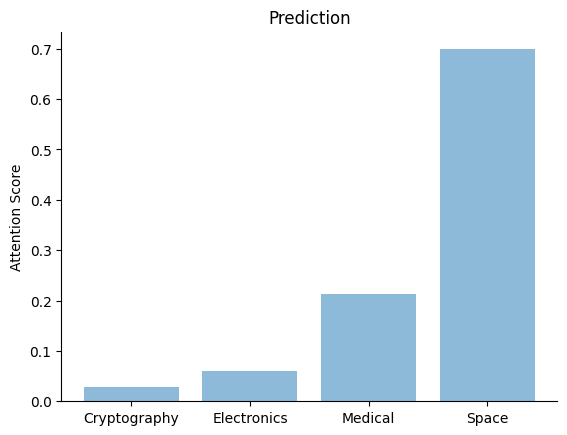

In [79]:

checkpoint = torch.load("best_model/model.pth.tar")
model = checkpoint['model']
model.eval()

dataset = News20Dataset("glove.6B.100d.txt", is_train=False)
doc = "Amidst this cosmic symphony, instruments of perception extend our senses beyond the limitations of our mortal coil. We gaze through lenses of glass and metal, peering into realms unseen, where galaxies spiral in cosmic embrace. Signals, like ethereal messengers, traverse the void, carrying secrets encoded in the language of pulses and waves."

result = visualize(model, dataset, doc)

with open('result.html', 'w') as f:
    f.write(result)

webbrowser.open_new('file://'+os.getcwd()+'/result.html')

In [80]:
from IPython.display import HTML

# Read the HTML file content
with open('result.html', 'r') as file:
    html_content = file.read()

# Display the HTML content
display(HTML(html_content))
